In [1]:
import math
import os
import warnings

import lightly
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import timm
import torch
import torchvision
from lightly.loss import NegativeCosineSimilarity
from lightly.models import utils
from lightly.models.modules import (
    SimSiamPredictionHead,
    SimSiamProjectionHead,
    heads,
    masked_autoencoder,
)
from lightly.utils import scheduler
from models.fastsiam import (
    FastSiam,
    fastsiam_convnextv2_nano,
    fastsiam_resnet18,
    fastsiam_resnet18_lightly,
)
import plotly.express as px
from pytorch_lightning.callbacks import RichProgressBar
from torch import nn
import umap
from utilities.benchmarking import KNNBenchmarkModule
from utilities.data import WaferMapDataset, get_inference_transforms
from utilities.embeddings import extract_embeddings

torch.set_float32_matmul_precision("high")

# suppress annoying torchmetrics and lightning warnings
warnings.filterwarnings("ignore", ".*has Tensor cores.*")
warnings.filterwarnings("ignore", ".*interpolation.*")
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*meaningless.*")
warnings.filterwarnings("ignore", ".*log_every_n_steps.*")

Issues with loading checkpoints: https://github.com/Lightning-AI/lightning/issues/2909

In [2]:
# Load data splits
train_1_split = pd.read_pickle("../data/cleaned_splits/train_1_split.pkl")
train_10_split = pd.read_pickle("../data/cleaned_splits/train_10_split.pkl")
train_20_split = pd.read_pickle("../data/cleaned_splits/train_20_split.pkl")
train_data = pd.read_pickle("../data/cleaned_splits/train_data.pkl")
val_data = pd.read_pickle("../data/cleaned_splits/val_data.pkl")
test_data = pd.read_pickle("../data/cleaned_splits/test_data.pkl")

# Create dictionary of data splits to easily get names for saved files
datasets = {
    "train": train_data,
    "train_1": train_1_split,
    "train_10": train_10_split,
    "train_20": train_20_split,
    "val": val_data,
    "test": test_data,
}

# Create LightlyDatasets and dataloaders
train_dataset = lightly.data.LightlyDataset.from_torch_dataset(
    WaferMapDataset(train_data.waferMap, train_data.failureCode),
    transform=get_inference_transforms(img_size=[224, 224]),
)
val_dataset = lightly.data.LightlyDataset.from_torch_dataset(
    WaferMapDataset(val_data.waferMap, val_data.failureCode),
    transform=get_inference_transforms(img_size=[224, 224]),
)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1024, shuffle=False
)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1024, shuffle=False
)

train_20_dataset = lightly.data.LightlyDataset.from_torch_dataset(
    WaferMapDataset(train_20_split.waferMap, train_20_split.failureCode),
    transform=get_inference_transforms(img_size=[224, 224]),
)
train_20_dataloader = torch.utils.data.DataLoader(
    train_20_dataset, batch_size=1024, shuffle=False
)

In [3]:
max_epochs = 200
lr_factor = 32 / 256
class MAEModel(KNNBenchmarkModule):
    def __init__(self, dataloader_kNN, num_classes, **kwargs):
        super().__init__(dataloader_kNN, num_classes, **kwargs)

        decoder_dim = 512
        vit = torchvision.models.vit_b_32()

        self.warmup_epochs = 40 if max_epochs >= 800 else 20
        self.mask_ratio = 0.75
        self.patch_size = vit.patch_size
        self.sequence_length = vit.seq_length
        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_dim))
        self.backbone = masked_autoencoder.MAEBackbone.from_vit(vit)
        self.decoder = masked_autoencoder.MAEDecoder(
            seq_length=vit.seq_length,
            num_layers=1,
            num_heads=16,
            embed_input_dim=vit.hidden_dim,
            hidden_dim=decoder_dim,
            mlp_dim=decoder_dim * 4,
            out_dim=vit.patch_size**2 * 3,
            dropout=0,
            attention_dropout=0,
        )
        self.criterion = nn.MSELoss()

    def forward_encoder(self, images, idx_keep=None):
        return self.backbone.encode(images, idx_keep)

    def forward_decoder(self, x_encoded, idx_keep, idx_mask):
        # build decoder input
        batch_size = x_encoded.shape[0]
        x_decode = self.decoder.embed(x_encoded)
        x_masked = utils.repeat_token(
            self.mask_token, (batch_size, self.sequence_length)
        )
        x_masked = utils.set_at_index(x_masked, idx_keep, x_decode)

        # decoder forward pass
        x_decoded = self.decoder.decode(x_masked)

        # predict pixel values for masked tokens
        x_pred = utils.get_at_index(x_decoded, idx_mask)
        x_pred = self.decoder.predict(x_pred)
        return x_pred

    def training_step(self, batch, batch_idx):
        images, _, _ = batch

        batch_size = images.shape[0]
        idx_keep, idx_mask = utils.random_token_mask(
            size=(batch_size, self.sequence_length),
            mask_ratio=self.mask_ratio,
            device=images.device,
        )
        x_encoded = self.forward_encoder(images, idx_keep)
        x_pred = self.forward_decoder(x_encoded, idx_keep, idx_mask)

        # get image patches for masked tokens
        patches = utils.patchify(images, self.patch_size)
        # must adjust idx_mask for missing class token
        target = utils.get_at_index(patches, idx_mask - 1)

        loss = self.criterion(x_pred, target)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.AdamW(
            self.parameters(),
            lr=1.5e-4 * lr_factor,
            weight_decay=0.05,
            betas=(0.9, 0.95),
        )
        cosine_scheduler = scheduler.CosineWarmupScheduler(
            optim, self.warmup_epochs, max_epochs
        )
        return [optim], [cosine_scheduler]
    
    def predict_step(self, batch, batch_idx):
        images, _, _ = batch
        return self.backbone(images)
        

model = MAEModel(None, 9)
# ckpt_path = "benchmark_logs/wafermaps/version_11/MAE/checkpoints/epoch=135-step=211616.ckpt"
ckpt_path = "benchmark_logs/wafermaps/version_0/MAE/checkpoints/epoch=199-step=62200.ckpt"
ckpt_path = "benchmark_logs/ti_run/MAE/checkpoints/epoch=199-step=62200.ckpt"
model.load_state_dict(torch.load(ckpt_path)["state_dict"])

<All keys matched successfully>

In [4]:
trainer = pl.Trainer(accelerator="gpu", callbacks=[RichProgressBar()], logger=False)
preds = trainer.predict(model, train_20_dataloader)
# Note that this returns a list of tensors, one for each batch
# We need to concatenate them to get the predictions for the whole dataset
preds = torch.cat(preds, dim=0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

The stuff below could go into a function in utilities/embeddings.py

In [5]:
reducer = umap.UMAP(random_state=0)
embeddings = reducer.fit_transform(preds)

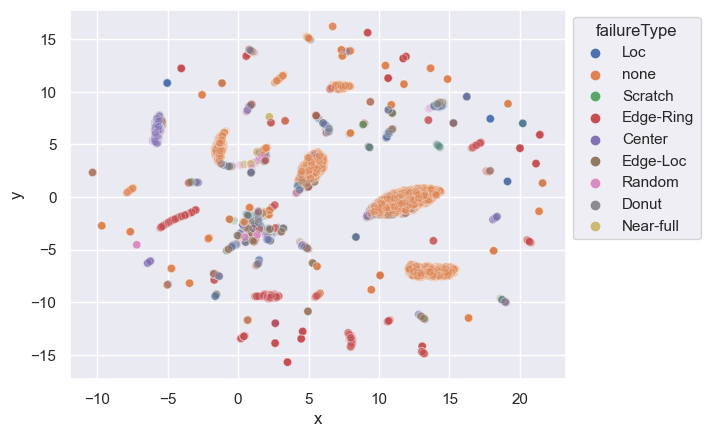

In [6]:
emb_df = pd.DataFrame(embeddings, columns=["x", "y"])
emb_df["failureType"] = train_20_split.failureType.values
# emb_df.sort_values(by="failureType", inplace=True)

sns.set_theme()

ax = sns.scatterplot(
    data=emb_df, x="x", y="y", hue="failureType", alpha=0.3
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

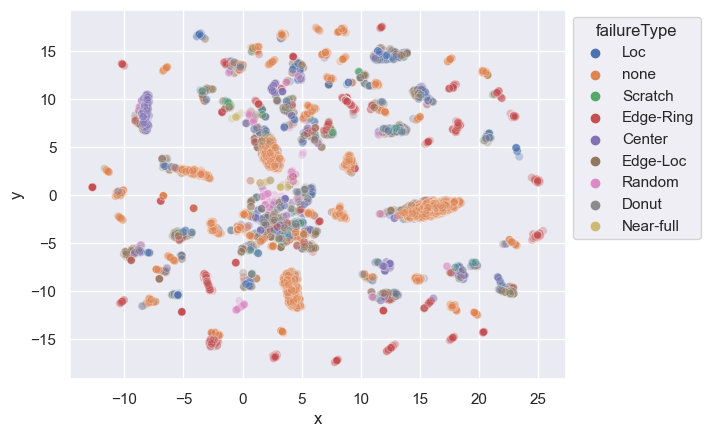

In [7]:
reducer = umap.UMAP(random_state=0, densmap=True, dens_lambda=.2)
embeddings = reducer.fit_transform(preds)
emb_df = pd.DataFrame(embeddings, columns=["x", "y"])
emb_df["failureType"] = train_20_split.failureType.values
# emb_df.sort_values(by="failureType", inplace=True)

sns.set_theme()

ax = sns.scatterplot(
    data=emb_df, x="x", y="y", hue="failureType", alpha=0.3
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [8]:
px.colors.qualitative.swatches()

In [8]:
fig = px.scatter(emb_df, x="x", y="y", color="failureType", width=800, height=600, opacity=1, color_discrete_sequence=px.colors.qualitative.Plotly)
fig.show()

## OLD CODE 👴👵
## CODE GRAVEYARD BELOW 🪦⚰️💀

Extracting embeddings for train_1 data


100%|██████████| 623/623 [00:28<00:00, 22.17it/s]


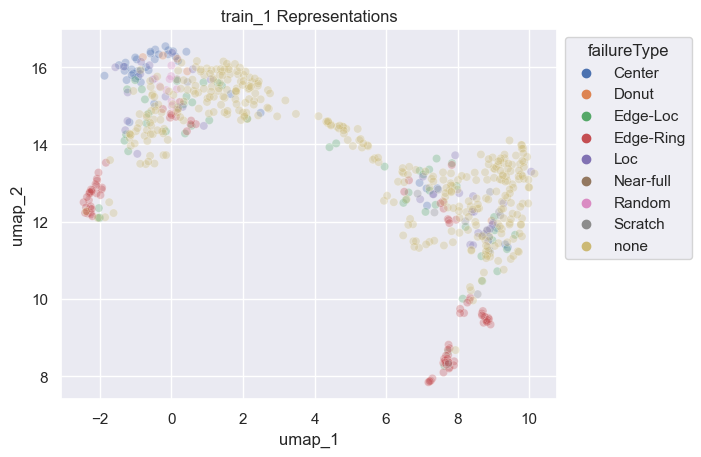

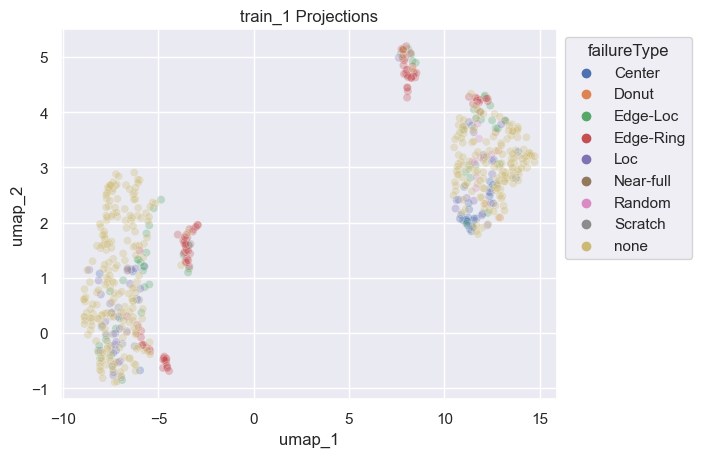

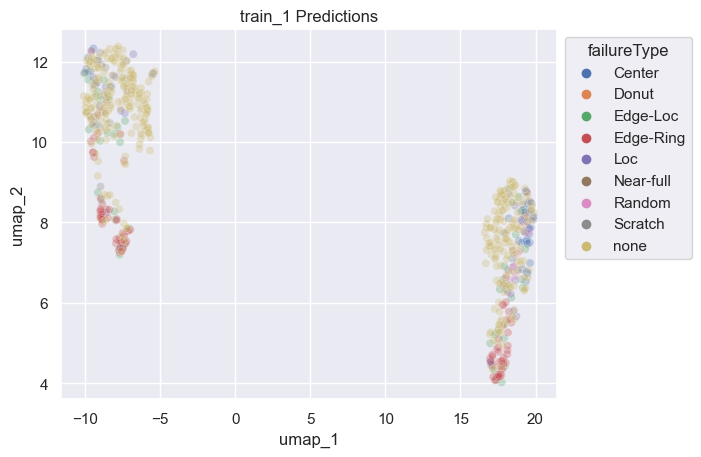

Extracting embeddings for train_10 data


100%|██████████| 6225/6225 [04:48<00:00, 21.60it/s]


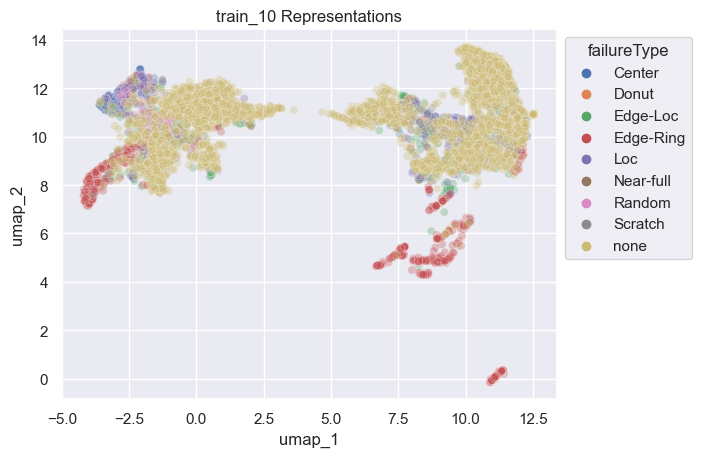

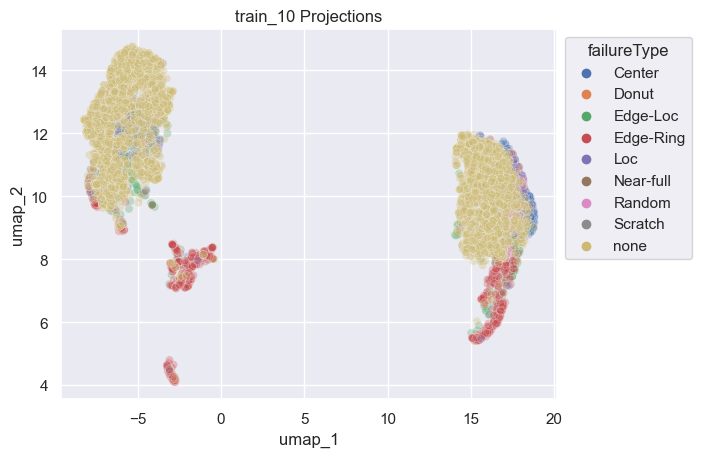

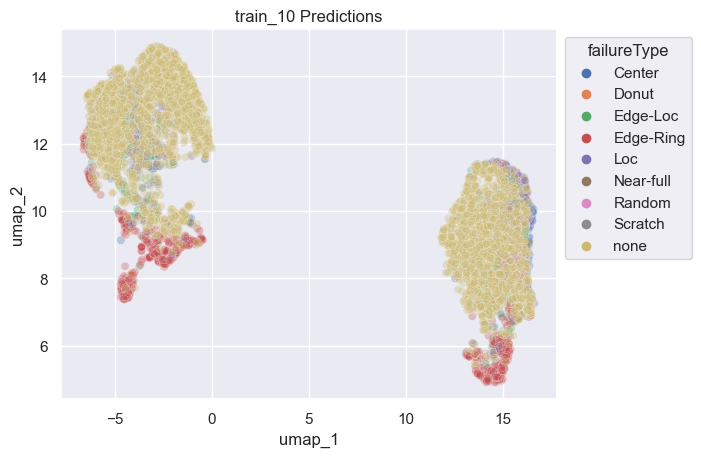

Extracting embeddings for train_20 data


100%|██████████| 12449/12449 [12:26<00:00, 16.68it/s]


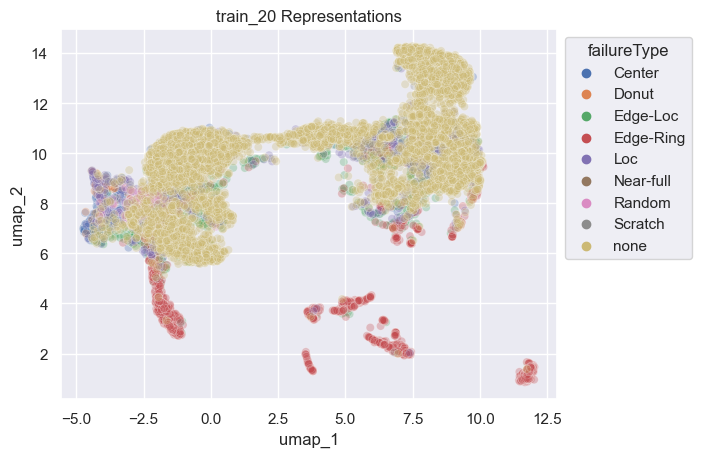

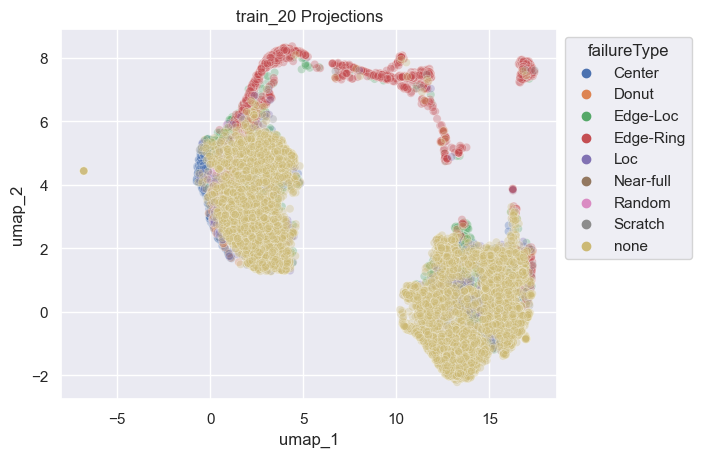

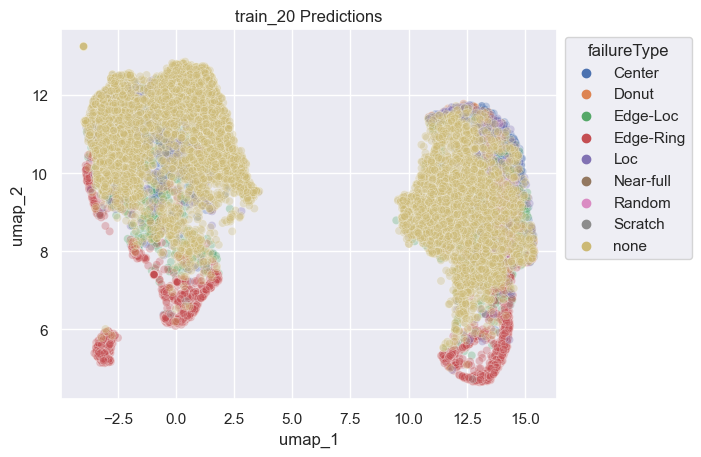

Extracting embeddings for val data


100%|██████████| 12450/12450 [13:40<00:00, 15.17it/s]


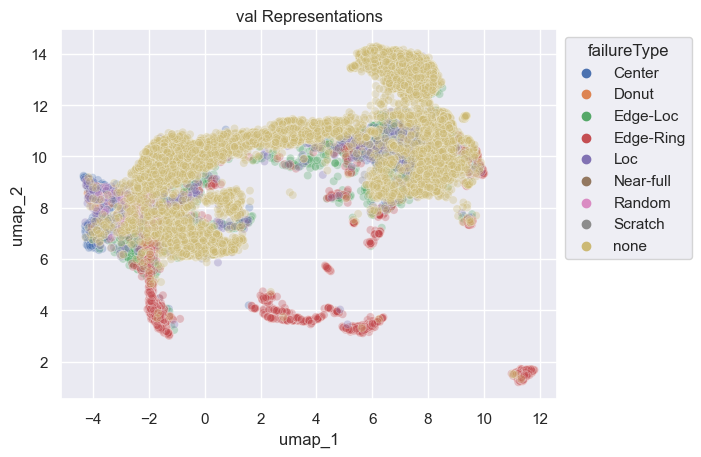

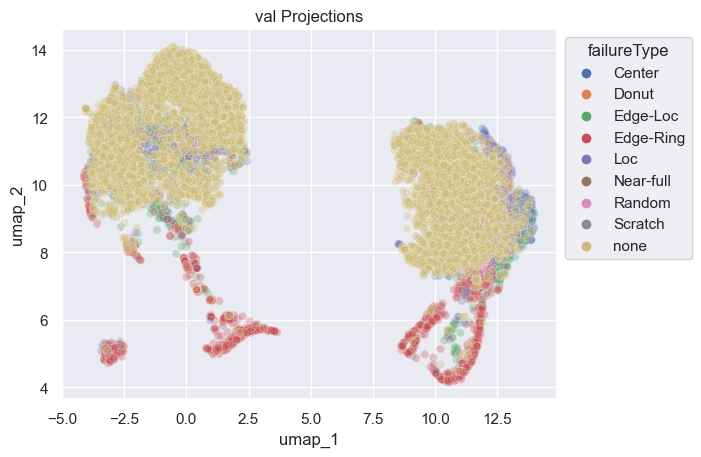

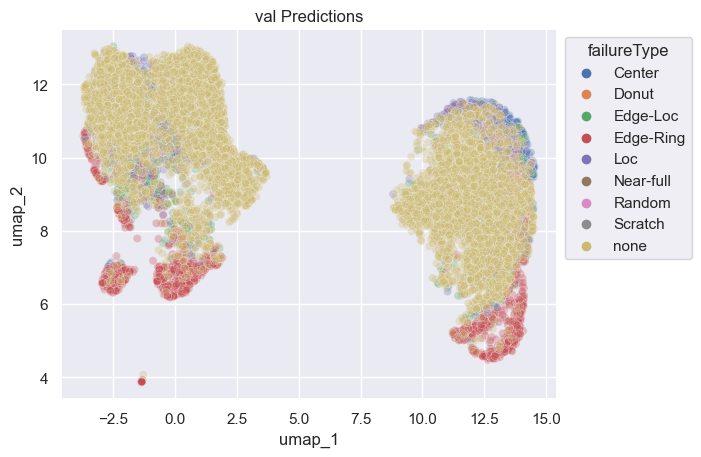

Extracting embeddings for test data


100%|██████████| 12450/12450 [14:02<00:00, 14.78it/s]


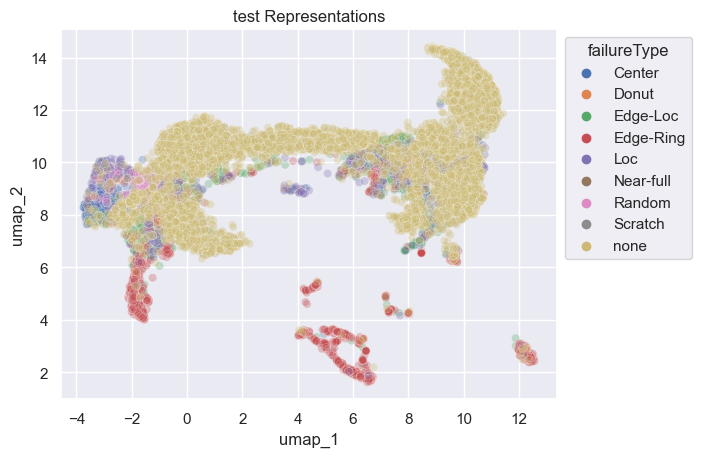

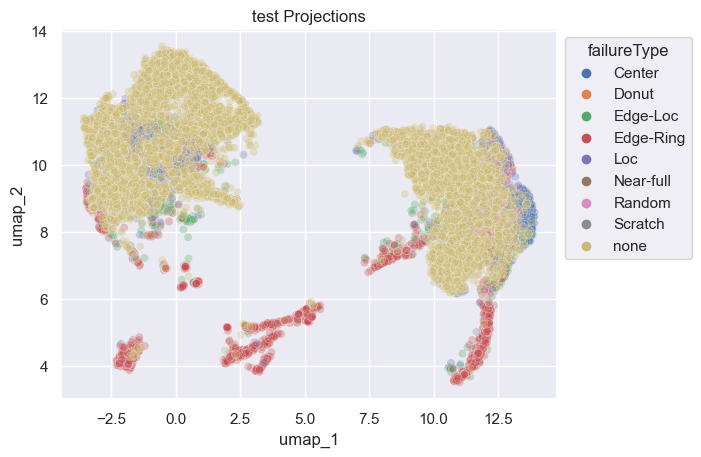

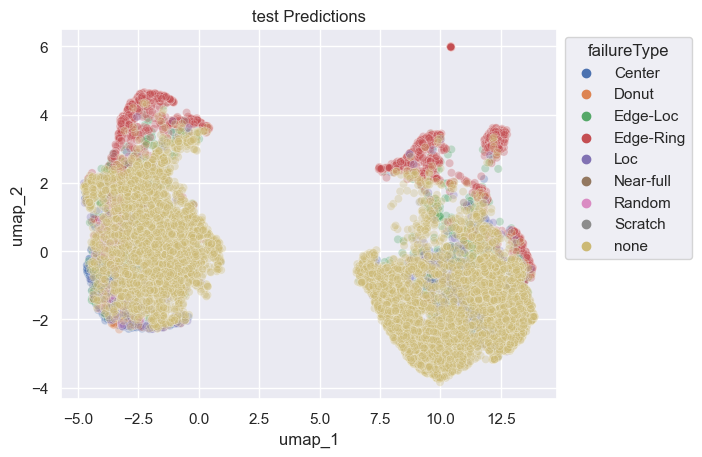

In [5]:
# Create and load FastSiam model from checkpoint
model = fastsiam_convnextv2_nano()
ckpt_path = "lightning_logs/convnextv2_nano_10ep_200/checkpoints/epoch=9-step=15560.ckpt"
# model = model.load_from_checkpoint(ckpt_path)
checkpoint = torch.load(ckpt_path)
model.load_state_dict(checkpoint["state_dict"])
model.eval()

# Extract embeddings for each data split and save to file
save_dir = "../data/embeddings/fastsiam_convnextv2_nano_10"
for name, data in datasets.items():
    print(f"Extracting embeddings for {name} data")
    extract_embeddings(
        model=model, data=data, img_size=[200, 200], save_dir=save_dir, name=name
    )

In [11]:
class FastSiam(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # create a ResNet backbone and remove the classification head
        # See https://github.com/lightly-ai/lightly/blob/7d3bc64ac3372c6e7ec8e24a8c56fb499209957f/lightly/models/resnet.py
        resnet = lightly.models.ResNetGenerator("resnet-18")
        self.backbone = nn.Sequential(
            *list(resnet.children())[:-1], nn.AdaptiveAvgPool2d(1)
        )
        # Original paper uses dimension d=2048. We use 1024 here for lower complexity.
        self.projection_head = SimSiamProjectionHead(512, 1024, 1024)
        # prediction MLP’s hidden layer dimension is always 1/4 of the output dimension
        self.prediction_head = SimSiamPredictionHead(1024, 256, 1024)
        self.criterion = NegativeCosineSimilarity()

    def forward(self, x):
        f = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(f)
        p = self.prediction_head(z)
        z = z.detach()
        return z, p

    def training_step(self, batch, batch_idx):
        # Unpack augmented views
        views, _, _ = batch
        x1, x2, x3, x4 = views

        # Pass each view through projector to get z, and predictor to get p
        z1, p1 = self.forward(x1)
        z2, p2 = self.forward(x2)
        z3, p3 = self.forward(x3)
        z4, p4 = self.forward(x4)

        # Use mean of the last N - 1 projected views
        mean = (z2 + z3 + z4) / 3

        # Compute loss using prediction of 1st view, mean of remaining projected views
        loss = self.criterion(p1, mean)

        # Keep a log of the loss
        self.log("loss", loss)

        return loss

    def configure_optimizers(self):
        # FastSiam authors use lr=0.125 (?!), SimSiam would use 0.00625 here. 0.06 is a happy medium :)
        optim = torch.optim.SGD(self.parameters(), lr=0.06)
        return optim

In [7]:
# Create and load FastSiam model from checkpoint
model = fastsiam_resnet18_lightly()
ckpt_path = "lightning_logs/r18_lightly_10/checkpoints/epoch=9-step=15560.ckpt"
# model = model.load_from_checkpoint(ckpt_path)
checkpoint = torch.load(ckpt_path)
model.load_state_dict(checkpoint["state_dict"])
model.eval()

FastSiam(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): B

Extracting embeddings for train_1 data


100%|██████████| 623/623 [00:54<00:00, 11.51it/s]


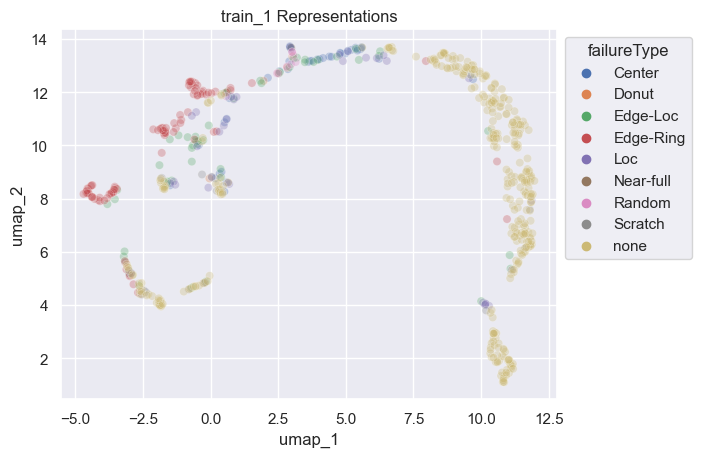

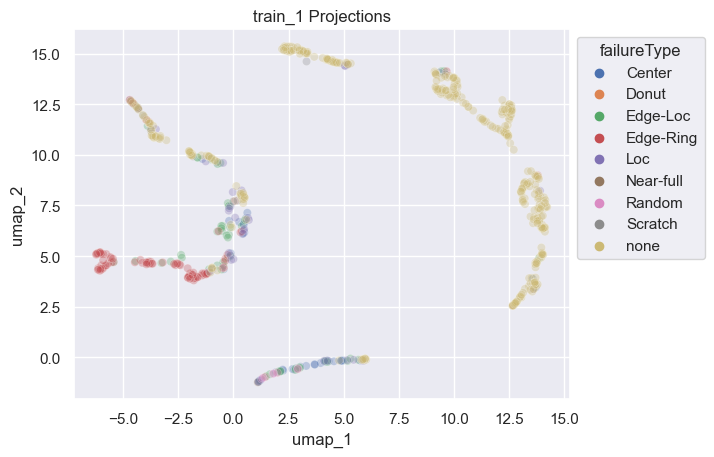

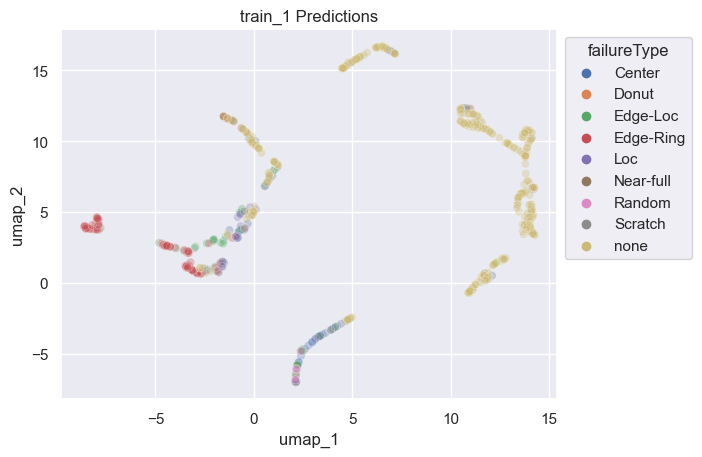

Extracting embeddings for train_10 data


100%|██████████| 6225/6225 [15:07<00:00,  6.86it/s]


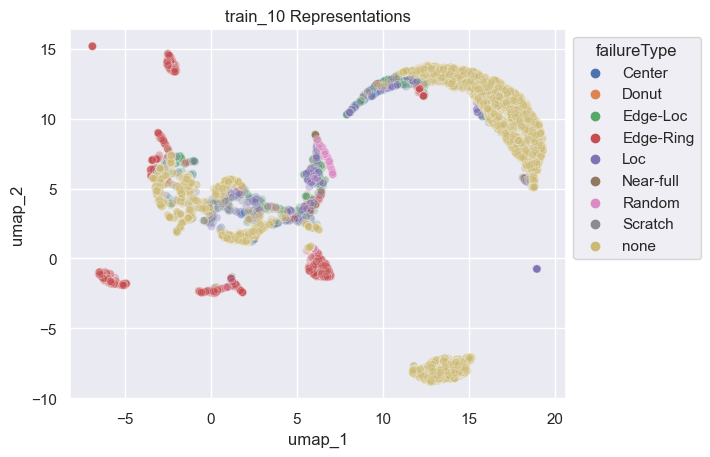

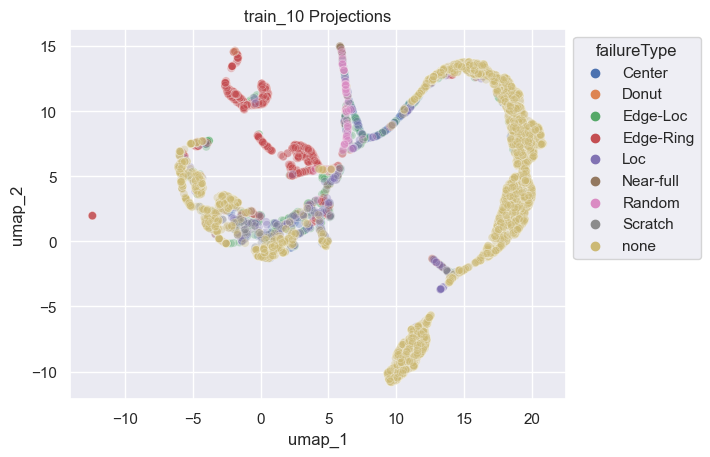

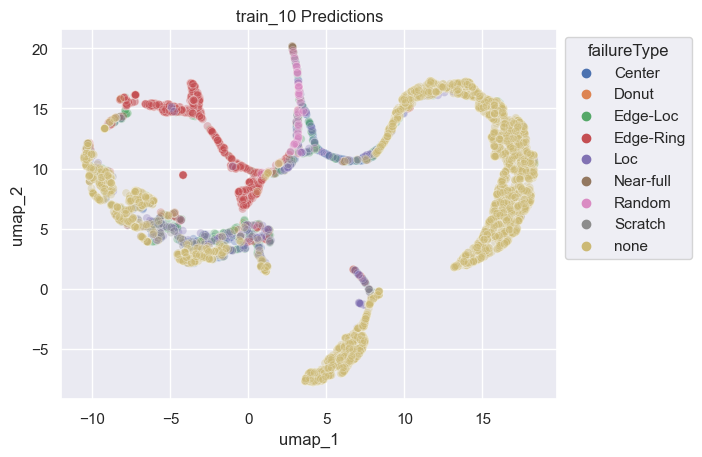

Extracting embeddings for train_20 data


100%|██████████| 12449/12449 [30:41<00:00,  6.76it/s]


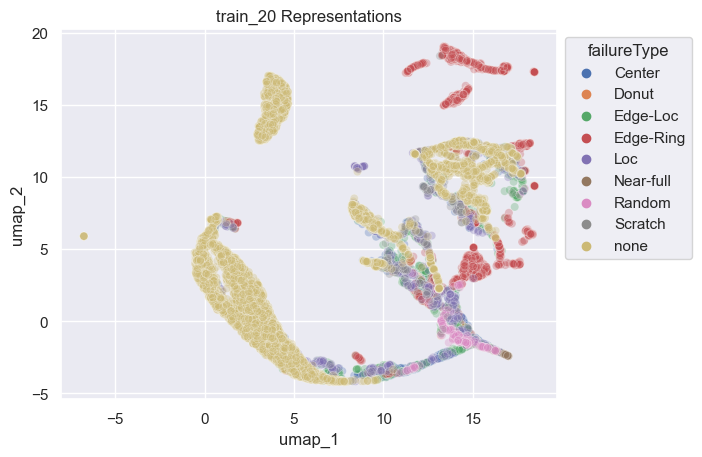

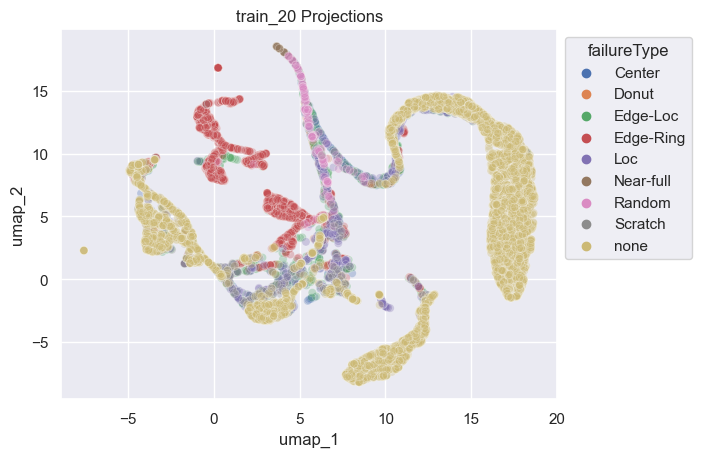

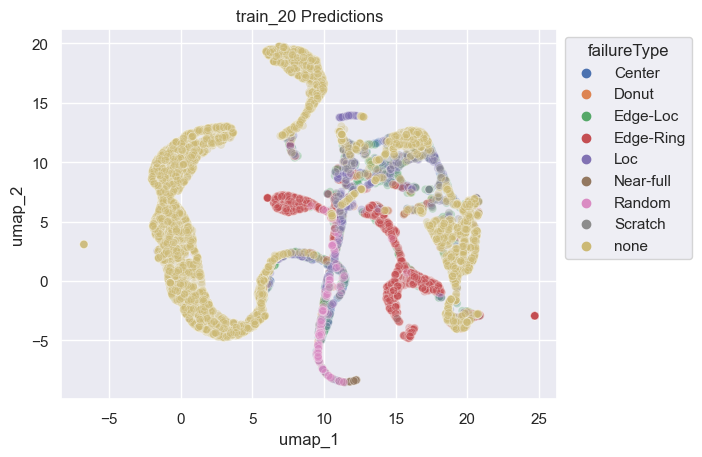

Extracting embeddings for val data


100%|██████████| 12450/12450 [20:02<00:00, 10.35it/s]


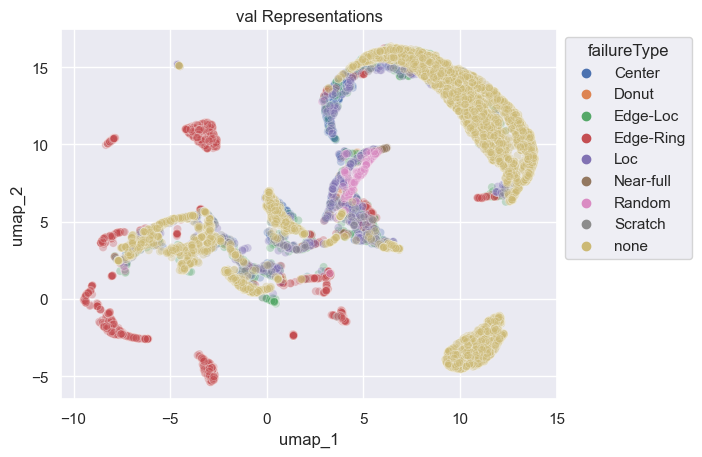

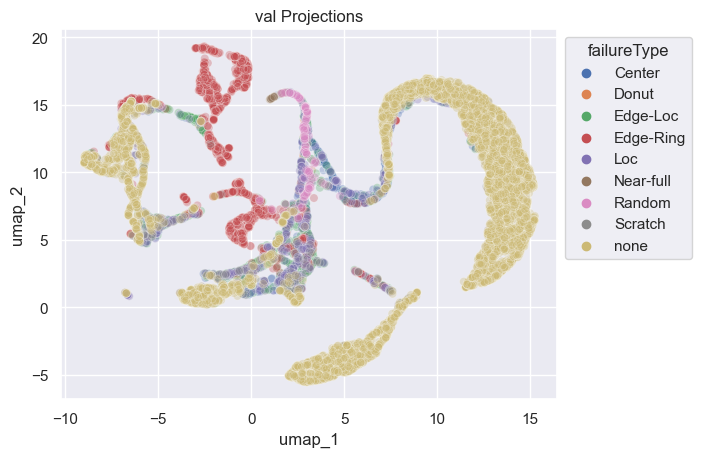

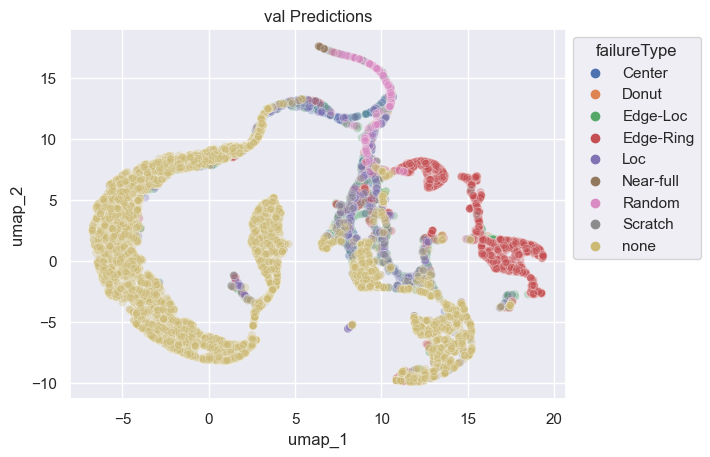

Extracting embeddings for test data


100%|██████████| 12450/12450 [21:52<00:00,  9.48it/s]


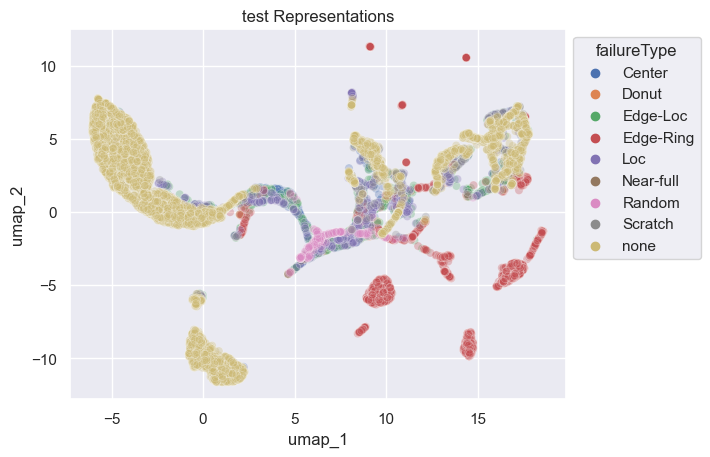

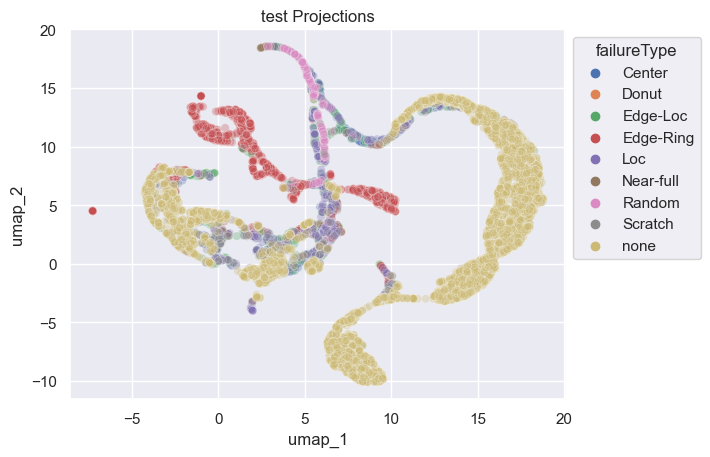

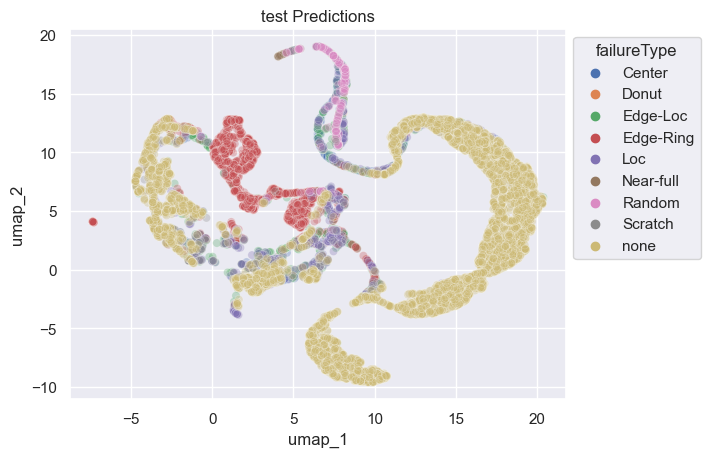

In [8]:
# Extract embeddings for each data split and save to file
save_dir = "../data/embeddings/fastsiam_r18_lightly_10"
for name, data in datasets.items():
    print(f"Extracting embeddings for {name} data")
    extract_embeddings(
        model=model, data=data, img_size=[128, 128], save_dir=save_dir, name=name
    )

In [ ]:
# Create and load FastSiam model from checkpoint
model = fastsiam_resnet18()
ckpt_path = "lightning_logs/r18_lightly_10/checkpoints/epoch=9-step=15560.ckpt"
# model = model.load_from_checkpoint(ckpt_path)
checkpoint = torch.load(ckpt_path)
model.load_state_dict(checkpoint["state_dict"])
model.eval()

In [12]:
ckpt_path = "lightning_logs/r18_lightly_10/checkpoints/epoch=9-step=15560.ckpt"
model = FastSiam.load_from_checkpoint(ckpt_path)
# Extract embeddings for each data split and save to file
save_dir = "../data/embeddings/fastsiam_r18_lightly_10"
for name, data in datasets.items():
    print(f"Extracting embeddings for {name} data")
    extract_embeddings(model, data, save_dir, name=name)

FileNotFoundError: [Errno 2] No such file or directory: 'd:/Documents/GitHub/fastsiam-wafers/scripts/lightning_logs/version_8/checkpoints/epoch=9-step=15560.ckpt'

In [ ]:
class FastSiam(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # create a ConvNeXt model without the fc layer head
        # self.backbone = timm.create_model("convnext_nano", num_classes=0)
        self.backbone = timm.create_model("resnet18", num_classes=0)
        # Original paper uses dimension d=2048. We use 1024 here for lower complexity.
        self.projection_head = SimSiamProjectionHead(512, 1024, 1024)
        # prediction MLP’s hidden layer dimension is always 1/4 of the output dimension
        self.prediction_head = SimSiamPredictionHead(1024, 256, 1024)
        self.criterion = NegativeCosineSimilarity()

    def forward(self, x):
        f = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(f)
        p = self.prediction_head(z)
        z = z.detach()
        return z, p

    def training_step(self, batch, batch_idx):
        # Unpack augmented views
        views, _, _ = batch
        x1, x2, x3, x4 = views

        # Pass each view through projector to get z, and predictor to get p
        z1, p1 = self.forward(x1)
        z2, p2 = self.forward(x2)
        z3, p3 = self.forward(x3)
        z4, p4 = self.forward(x4)

        # Use mean of the last N - 1 projected views
        mean = (z2 + z3 + z4) / 3

        # Compute loss using prediction of 1st view, mean of remaining projected views
        loss = self.criterion(p1, mean)

        # Keep a log of the loss
        self.log("loss", loss)
        # Monitor the STD of L2-normalized representation to check if it collapses (bad)

        return loss

    def configure_optimizers(self):
        # FastSiam authors use lr=0.125 (?!), SimSiam would use 0.00625 here. 0.06 is a happy medium :)
        optim = torch.optim.SGD(self.parameters(), lr=0.06)
        return optim

Extracting embeddings for train_1 data


100%|██████████| 623/623 [00:09<00:00, 67.16it/s]


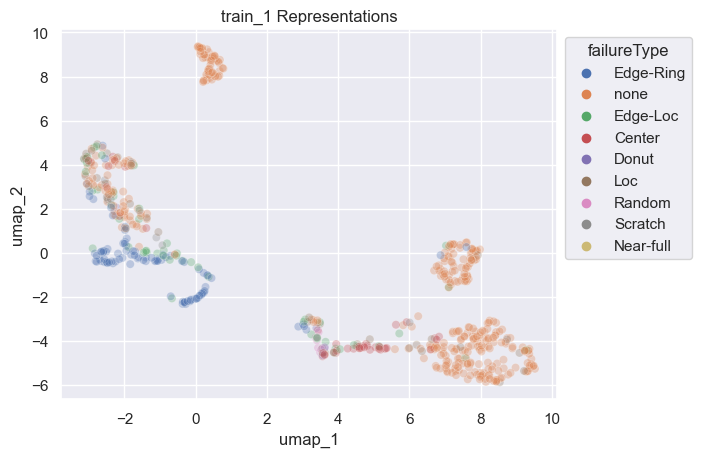

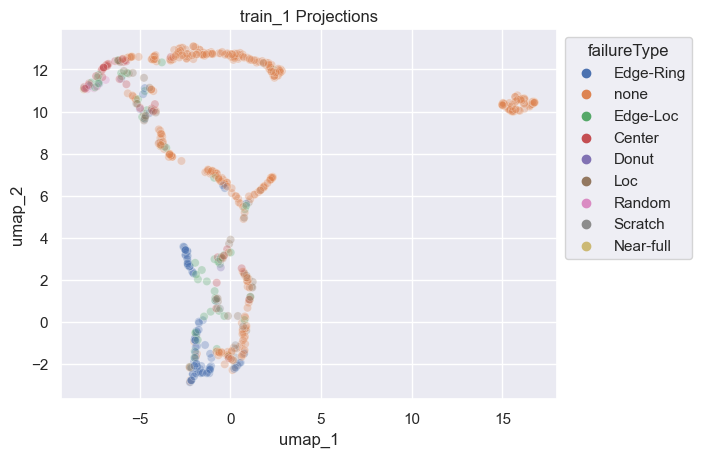

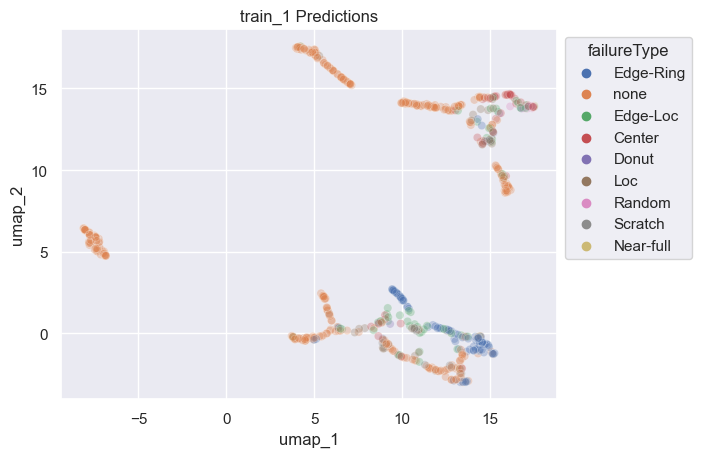

Extracting embeddings for train_10 data


 13%|█▎        | 840/6225 [00:13<01:26, 62.21it/s]


KeyboardInterrupt: 

In [ ]:
ckpt_path = "lightning_logs/r18_timm_25/checkpoints/epoch=24-step=19450.ckpt"
model = FastSiam.load_from_checkpoint(ckpt_path)
# Extract embeddings for each data split and save to file
save_dir = "../data/embeddings/fastsiam_r18_timm_25"
for name, data in datasets.items():
    print(f"Extracting embeddings for {name} data")
    extract_embeddings(model, data, save_dir, name=name)